In [1]:
# Source:
# https://www.youtube.com/watch?v=65kl4eE9ovI&ab_channel=Mr.PSolver
# https://github.com/lukepolson/youtube_channel/blob/3642cdd80f9200a5db4e622a3fe2c1a8f6868ecd/Python%20Metaphysics%20Series/vid28.ipynb

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science','notebook'])
from itertools import combinations

In [3]:
X_COORD = 0
Y_COORD = 1

In [4]:
n_particles = 16
radius = 0.06

r = np.random.random((2, n_particles)) # Generates a 2 x n_particles array, values between 0..1

#  boolean indexing, works as a filter
ixr = r[X_COORD] > 0.5
ixl = r[X_COORD] <= 0.5

In [5]:
ids = np.arange(n_particles)

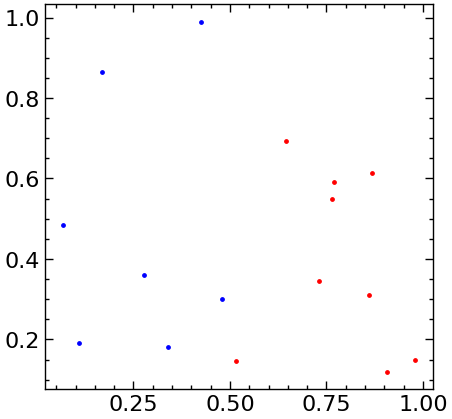

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(r[X_COORD][ixl],r[Y_COORD][ixl], color='b', s=6)
plt.scatter(r[X_COORD][ixr],r[Y_COORD][ixr], color='r', s=6)


(array([2., 1., 2., 1., 2., 0., 1., 3., 2., 2.]),
 array([0.06704884, 0.15832991, 0.24961097, 0.34089204, 0.4321731 ,
        0.52345417, 0.61473523, 0.7060163 , 0.79729737, 0.88857843,
        0.9798595 ]),
 <BarContainer object of 10 artists>)

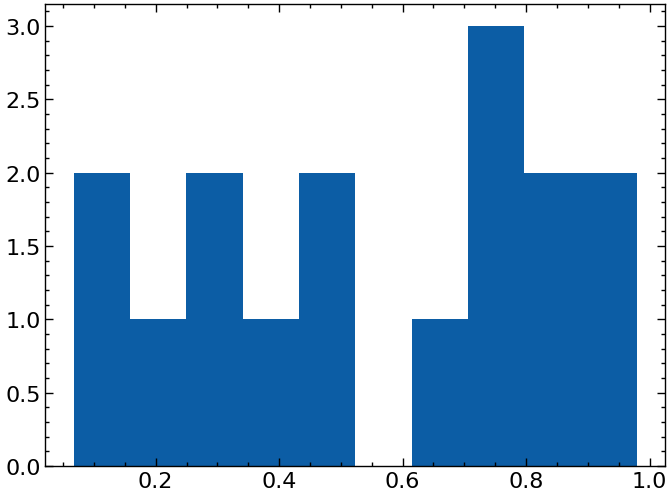

In [7]:
plt.hist(r[0])

In [8]:
v = np.zeros((2, n_particles))

In [9]:
# Initial velocities
v[X_COORD][ixr] = -500
v[Y_COORD][ixl] = 500

In [10]:
# get cartesian pairs with all particles x all particles
ids_pairs = np.asarray(list(combinations(ids,2))) # <- keeps track of ALL particles pairs

In [11]:
# ids_pairs

In [12]:
x_pairs = np.asarray(list(combinations(r[X_COORD],2))) # <- r is the coordinates array, so x_pairs are the x positions of all particles
y_pairs = np.asarray(list(combinations(r[Y_COORD],2))) # <- same, but for y.

In [13]:
dx_pairs = np.diff(x_pairs, axis=1).ravel()
dy_pairs = np.diff(x_pairs, axis=1).ravel()
d_pairs = np.sqrt(dx_pairs**2 + dx_pairs**2) # Distance between every two particles

In [14]:
ids_pairs_collide = ids_pairs[d_pairs < 2 * radius]

In [15]:
ids_pairs_collide

array([[ 0, 12],
       [ 1, 11],
       [ 1, 12],
       [ 2, 10],
       [ 2, 15],
       [ 3,  4],
       [ 3,  5],
       [ 3, 14],
       [ 5, 14],
       [ 6,  8],
       [ 6,  9],
       [10, 15],
       [11, 13]])

In the line of code v1 = v[:, ids_pairs_collide[:,0]], there are a few key components to understand:

v[:, ids_pairs_collide[:,0]]:

v: This is likely a NumPy array.
:: This colon means "select all rows" in the array v.
ids_pairs_collide[:,0]: This part is selecting the first column (index 0) from the ids_pairs_collide array.
Array Indexing:

ids_pairs_collide[:,0]: This selects all rows from the first column of the ids_pairs_collide array. If ids_pairs_collide is a 2D array, this will return a 1D array containing the elements from the first column.
v[:, ids_pairs_collide[:,0]]: This uses the 1D array obtained from ids_pairs_collide[:,0] to index the columns of v. Essentially, it selects all rows from v and specific columns as indicated by the values in ids_pairs_collide[:,0].
To summarize, v1 will be a new array that contains all rows from v but only the columns specified by the first column of ids_pairs_collide.

In [16]:
v1 = v[:, ids_pairs_collide[:,0]] # all x's from v in ids_pairs_collide
v2 = v[:, ids_pairs_collide[:,1]] # all y's from v in ids_pairs_collide
r1 = r[:, ids_pairs_collide[:,0]]
r2 = r[:, ids_pairs_collide[:,1]]


In [17]:
# ids_pairs_collide

In [18]:
ids_pairs_collide[:,1]

array([12, 11, 12, 10, 15,  4,  5, 14, 14,  8,  9, 15, 13])

In [19]:
# .T = matrix transposal
#  @ = matrix multiplication

def get_new_v(_v1, _v2, _r1, _r2):
    return _v1 - np.diag((_v1-_v2).T@(_r1-_r2))/np.sum((_r1-_r2)**2, axis=0) * (_r1-_r2)

# _v1new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)
# _v2new = v1 - np.diag((v2-v1).T@(r2-r1))/np.sum((r2-r1)**2, axis=0) * (r2-r1)


In [20]:

v1new = get_new_v(v1, v2, r1, r2)
v2new = get_new_v(v2, v1, r2, r1)

In [21]:
v2new

array([[   0.        ,    0.        ,    0.        , -500.        ,
        -500.        , -500.        , -500.        , -500.        ,
        -500.        ,    0.        ,    0.        , -500.        ,
        -582.94579512],
       [ 500.        ,  500.        ,  500.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,  500.        ,  500.        ,    0.        ,
         368.94157183]])

In [22]:
def get_delta_pairs(x):
    return np.diff(np.asarray(list(combinations(x, 2))), axis=1).ravel()

def get_deltad_pairs(r):
    return np.sqrt(
        get_delta_pairs(r[0])**2 + get_delta_pairs(r[1])**2
    )

def compute_new_v(_v1, _v2, _r1, _r2):
    return get_new_v(_v1, _v2, _r1, _r2), get_new_v(_v2, _v1, _r2, _r1)

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = np.zeros((ts, r.shape[0], r.shape[1]))     
    vs = np.zeros((ts, v.shape[0], v.shape[1]))     
    # Initial state
    rs[0] = r.copy()
    vs[0] = v.copy()

    for i in range(1, ts):
        ic = id_pairs[get_deltad_pairs(r) < d_cutoff]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(
            v[:,ic[:,0]], v[:,ic[:,1]],
            r[:,ic[:,0]], r[:,ic[:,1]]
        )
        v[0, r[0] > 1] = -np.abs(v[0, r[0] > 1])
        v[0, r[0] < 0] = np.abs(v[0, r[0] < 0])
        v[1, r[1] > 1] = -np.abs(v[1, r[1] > 1])
        v[1, r[1] < 0] = np.abs(v[1, r[1] < 0])
        r = r + v * dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    
    return rs, vs


In [23]:
# radius = 0.06
# rs, vs = motion(r, v, ids_pairs, ts=1000, dt = 0.000008, d_cutoff=2*radius)

In [24]:
""" 
fig, ax = plt.subplots(1, 1, figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()
"""

" \nfig, ax = plt.subplots(1, 1, figsize=(5,5))\nxred, yred = rs[0][0][ixr], rs[0][1][ixr]\nxblue, yblue = rs[0][0][ixl], rs[0][1][ixl]\ncircles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)]\ncircles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)]\ncred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')\ncblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')\nax.add_collection(cred)\nax.add_collection(cblue)\nax.set_xlim(0,1)\nax.set_ylim(0,1)\nplt.show()\n"

In [25]:
"""
fig, ax = plt.subplots(1, 1, figsize=(5,5))

def animate(i):
    ax.clear()
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)]
    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save("ani3.gif", writer="pillow", fps=30, dpi=100)

"""

'\nfig, ax = plt.subplots(1, 1, figsize=(5,5))\n\ndef animate(i):\n    ax.clear()\n    xred, yred = rs[i][0][ixr], rs[i][1][ixr]\n    xblue, yblue = rs[i][0][ixl], rs[i][1][ixl]\n    circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xred, yred)]\n    circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(xblue, yblue)]\n    cred = matplotlib.collections.PatchCollection(circles_red, facecolors=\'red\')\n    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors=\'blue\')\n    ax.add_collection(cred)\n    ax.add_collection(cblue)\n    ax.set_xlim(0,1)\n    ax.set_ylim(0,1)\n\nani = animation.FuncAnimation(fig, animate, frames=500, interval=50)\nani.save("ani3.gif", writer="pillow", fps=30, dpi=100)\n\n'

In [26]:
# The real simulation

n_particles = 400
r = np.random.random((2, n_particles))
ixr = r[0] > 0.5
ixl = r[0]<= 0.5
ids = np.arange(n_particles)
ids_pairs = np.asarray(list(combinations(ids,2)))
v = np.zeros((2, n_particles))
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0015

rs, vs = motion(r, v, ids_pairs, ts=5000, dt = 0.000008, d_cutoff=2*radius)

In [27]:
"""
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ani = animation.FuncAnimation(fig, animate, frames=500, interval=50)
ani.save("ani4.gif", writer="pillow", fps=30, dpi=100)
"""

'\nfig, ax = plt.subplots(1, 1, figsize=(5,5))\n\nani = animation.FuncAnimation(fig, animate, frames=500, interval=50)\nani.save("ani4.gif", writer="pillow", fps=30, dpi=100)\n'

$kT = K E_{avg} = \frac{1}{2} mv^2 \rightarrow \frac{m}{kT} = \frac{2}{v^2}$

$f(v) = \frac{m}{kT} v exp\left( - \frac{m}{kT} \frac{v^2}{2}\right)$

In [28]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2/2)

In [29]:
# Histogram

bins = np.linspace(0, 1500, 150)

# Green line
"""
plt.figure()
plt.hist(np.sqrt(np.sum(vs[-1]**2, axis=0)), bins=bins, density=True)
plt.plot(v, fv)
plt.xlabel("Velocity [m/s]")
plt.ylabel("Particles")
"""

'\nplt.figure()\nplt.hist(np.sqrt(np.sum(vs[-1]**2, axis=0)), bins=bins, density=True)\nplt.plot(v, fv)\nplt.xlabel("Velocity [m/s]")\nplt.ylabel("Particles")\n'

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

def animate(i):
    [ax.clear() for ax in axes]
    ax = axes[0]
    xred, yred = rs[i][0][ixr], rs[i][1][ixr]
    xblue, yblue = rs[i][0][ixl],rs[i][1][ixl]
    circles_red = [plt.Circle((xi, yi), radius=4*radius, linewidth=0) for xi,yi in zip(xred,yred)]
    circles_blue = [plt.Circle((xi, yi), radius=4*radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
    cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
    cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
    ax.add_collection(cred)
    ax.add_collection(cblue)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax = axes[1]
    ax.hist(np.sqrt(np.sum(vs[i]**2, axis=0)), bins=bins, density=True)
    ax.plot(v,fv)
    ax.set_xlabel('Velocity [m/s]')
    ax.set_ylabel('# Particles')
    ax.set_xlim(0,1500)
    ax.set_ylim(0,0.006)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.tight_layout()
    
    
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('ani_histo.gif',writer='pillow',fps=30,dpi=100)